# Welcome to the Retail Demo Store <a class="anchor" id="top"></a>

Congratulations! You have just been hired by the Retail Demo Store, which is a new online retail store that launched and is jumping into the crowded space of online sales. You have been hired into the Search & Discovery team, which leads efforts around personalization. Currently, most of your app does not provide a personalized experience, the products are presented in a static order for all users. In order to prevent customer churn and increase sales, you are looking to add personalized experiences. 

You’ve been asked by the founders to:

- Increase subscriber engagement by tailoring every experience to individual users
- Help users discover newly released products
- Increase the breadth of content offered to them from the Retail Demo Store catalog
- Reduce the time to value by creating valuable recommendations in a short time

Throughout the course of this workshop you will be exploring your datasets, building/training several recommendation models and implementing recommendations with API's.

<div class="alert alert-block alert-warning">
<b>Note:</b> importing and training the datasets will take longer than we have in this workshop. In order to complete this workshop within the time set, we have already created several resources on your behalf.  However, the notebooks are designed in such a way that all the steps are included. If the resources have already been created, the cell will return information about the resources, if the resources have not been created, it will create them for you. 
</div>


## In this notebook
In this notebook, you will choose a dataset and prepare it for use with Amazon Personalize.

1. [How to Use the Notebook](#usenotebook)
1. [Introduction to Amazon Personalize Datasets](#datasets)
1. [Choose a Dataset or Data Source](#source)
1. [Configure an S3 bucket and an IAM role](#bucket_role)
1. [Create dataset group](#group_dataset)
1. [Create the Interactions Schema](#interact_schema)
1. [Create the Items Schema](#items_schema)
1. [Create the Users Schema](#users_schema)
1. [Import the Interactions Data](#import_interactions)
1. [Import the Items Metadata](#import_items)
1. [Import the User Metadata](#import_users)
1. [Storing Useful Variables](#vars)

## How to Use the Notebook <a class="anchor" id="usenotebook"></a>

### Executing cells

The code is broken up into cells like the one below. There's a triangular **Run** button at the top of this page that you can click to execute each cell and move onto the next, or you can press `Shift` + `Enter` while in the cell to execute it and move onto the next one.

As a cell is executing, you'll notice an `*` in the checkbox beside the cell. When the cell has finished running, the checkbox will contain a number to indicate the order the cell was executed in with respect to all the other cells in the notebook.

Simply follow the instructions below and execute the cells to get started with Amazon Personalize.

### Understanding the code

This notebook can be used in two modalities:

1. Train as you go by executing each cell. Some cells may take a long time to finish executing as they wait for resources to be created.
2. Use this notebook with previously created resources. All or the majority of the resources will already be created, and cells will just retrieve the information of these existing resources to use them in following steps.

Because of this, you will find that some cells have `try` and `except` blocks. In particular, most of them are handling a `ResourceAlreadyExistsException` exception. 

You can look at the code in the `try` block to get a good idea of how you can create a resource and understand how to use the Amazon Personalize SDK. The `except` block will let you know that the resource has been created and record the corresponding ARN, which is the Amazon unique identifier.

This is an example of the `try` block for creating a dataset group, this code will execute without exceptions if the dataset group does not exist and raise an exception if the dataset group does already exist:

```python
try:     
    # Try to create the dataset group, this block with exectute fully if the dataset group does not exist yet
    
    create_dataset_group_response = personalize.create_dataset_group(
        name = workshop_dataset_group_name,
        domain='ECOMMERCE'
    )
    workshop_dataset_group_arn = create_dataset_group_response['datasetGroupArn']
    print(json.dumps(create_dataset_group_response, indent=2))
    print ('\nCreating the Dataset Group with dataset_group_arn = {}'.format(workshop_dataset_group_arn))
```
and this is the corresponding `except` block that will be executed if an exception is raised because the dataset group already exists. This block saves the ARN for the existing dataset group to use later and lets you know the resource already exists.

```python
except personalize.exceptions.ResourceAlreadyExistsException as e:
    workshop_dataset_group_arn = 'arn:aws:personalize:'+region+':'+account_id+':dataset group/' + 
        workshop_dataset_group_name 
    print ('\nThe the Dataset Group with dataset_group_arn = {} already exists'.format(
        workshop_dataset_group_arn))
    print ('\nWe will be using the existing Dataset Group dataset_group_arn = {}'.format(
        workshop_dataset_group_arn))
```

Depending on the resource, you may also find that sometimes the code will check from a list of resources to find if a resource exists and then use `if` and `else` blocks to either use the existing resource or create it.

### Let's build!

Python ships with a broad collection of libraries and we need to import those as well as the ones installed to help us like [boto3](https://aws.amazon.com/sdk-for-python/) (AWS SDK for python) and [Pandas](https://pandas.pydata.org/)/[Numpy](https://numpy.org/)  which are core data science tools.

In [1]:
# Get the latest version of botocore to ensure we have the latest features in the SDK
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade --no-deps --force-reinstall botocore
import os.path
import boto3
import json
import pandas as pd
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import time
from time import sleep
import csv
import yaml
from datetime import datetime
data_dir = "poc_data"

!mkdir $data_dir
!mkdir $data_dir/data
!mkdir $data_dir/metadata

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.35.3
    Uninstalling botocore-1.35.3:
      Successfully uninstalled botocore-1.35.3
mkdir: cannot create directory ‘poc_data’: File exists
mkdir: cannot create directory ‘poc_data/data’: File exists
mkdir: cannot create directory ‘poc_data/metadata’: File exists


In [2]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

In [3]:
# Get the account id and region to use later
account_id = boto3.client('sts').get_caller_identity().get('Account')
print("account id:", account_id)

with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print("region:", region)

account id: 809697808660
region: us-east-1


If this is a workshop and the resources were created for you, we will retrieve the variables of the resources created.

In [4]:
# Opening JSON files
f = open('params.json')
parameters = json.load(f)

f = open('params_data.json')
parameters_data = json.load(f)

In [5]:
workshop_dataset_group_name = parameters['datasetGroup']['serviceConfig']['name']

interactions_schema_name = parameters['datasets']['interactions']['schema']['serviceConfig']['name']
interactions_dataset_name = parameters['datasets']['interactions']['dataset']['serviceConfig']['name']

items_schema_name = parameters['datasets']['items']['schema']['serviceConfig']['name']
items_dataset_name = parameters['datasets']['items']['dataset']['serviceConfig']['name']

users_schema_name = parameters['datasets']['users']['schema']['serviceConfig']['name']
users_dataset_name = parameters['datasets']['users']['dataset']['serviceConfig']['name']

#The following job names are the starting Strings of the job names that can be created
interactions_import_job_name = 'dataset_import_interaction'
items_import_job_name = 'dataset_import_item'
users_import_job_name = 'dataset_import_user'

for recommender in parameters['recommenders']:
    # This is currently configured assuming only one recommender of each type, if there are multiple 
    # recommenders of the same type further configuration is needed.
    if (recommender['serviceConfig']['recipeArn'] == 'arn:aws:personalize:::recipe/aws-ecomm-customers-who-viewed-x-also-viewed'):
        recommender_customers_who_viewed_name =recommender['serviceConfig']['name'] 
    if (recommender['serviceConfig']['recipeArn'] == 'arn:aws:personalize:::recipe/aws-ecomm-recommended-for-you'):
        recommender_recommended_for_you_name =recommender['serviceConfig']['name']
        
for solution in parameters['solutions']:
    # This is currently configured assuming only one solution of this type, if there are multiple 
    # solutions of the same type further configuration is needed.
    if (solution['serviceConfig']['recipeArn'] == 'arn:aws:personalize:::recipe/aws-personalized-ranking'):
        workshop_rerank_solution_name = solution['serviceConfig']['name'] 
        # This is currently configured assuming only one campaign, if there are multiple campaigns 
        # further configuration is needed.
        workshop_rerank_campaign_name = solution['campaigns'][0]['serviceConfig']['name'] 

print ("Copying User metadata")
user_metadata_file_path = parameters_data['data_files']["user_metadata_file_path"]
!wget -P poc_data/metadata $user_metadata_file_path
# this will delete the zipped file. -k is not supported with the current version of gzip on this instance.

user_metadata_file_name = './poc_data/metadata/users.json'
if (os.path.isfile(user_metadata_file_name)):
    !rm $user_metadata_file_name  
    
zipped_user_user_metadata_file_name = user_metadata_file_name+'.gz'
    
!gzip -d $zipped_user_user_metadata_file_name

print ("Copying Item metadata")
item_metadata_file_path = parameters_data['data_files']["item_metadata_file_path"]
!wget -P poc_data/metadata $item_metadata_file_path
item_metadata_file_name = './poc_data/metadata/products.yaml'

raw_interactions_file_path = parameters_data['data_files']["interactions_file_path"]
raw_items_file_path = parameters_data['data_files']["items_file_path"]
raw_users_file_path = parameters_data['data_files']["users_file_path"]

Copying User metadata
--2024-08-22 20:24:11--  https://code.retaildemostore.retail.aws.dev/data/users.json.gz
Resolving code.retaildemostore.retail.aws.dev (code.retaildemostore.retail.aws.dev)... 18.165.83.109, 18.165.83.120, 18.165.83.129, ...
Connecting to code.retaildemostore.retail.aws.dev (code.retaildemostore.retail.aws.dev)|18.165.83.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1197415 (1.1M) [application/json]
Saving to: ‘poc_data/metadata/users.json.gz’

100%[======================================>] 1,197,415   --.-K/s   in 0.01s   

2024-08-22 20:24:12 (98.6 MB/s) - ‘poc_data/metadata/users.json.gz’ saved [1197415/1197415]

Copying Item metadata
--2024-08-22 20:24:12--  https://code.retaildemostore.retail.aws.dev/data/products.yaml
Resolving code.retaildemostore.retail.aws.dev (code.retaildemostore.retail.aws.dev)... 18.165.83.69, 18.165.83.129, 18.165.83.120, ...
Connecting to code.retaildemostore.retail.aws.dev (code.retaildemostore.retail.

we will make sure we can use the SDK to interact with Amazon Personalize by describing some of the pre-created resources used in the workshop. 

<div class="alert alert-block alert-warning">
<b>Note:</b> If you have not pre-deployed resources and are building them as you go with this notebook, the below cell will raise an exception. You can continue with the notebook and create resources and train models as you go.
</div>

If you have not pre-deployed resources and are building them as you go with this notebook, the below cell will raise an exception. You can continue with the notebook and create resources and train models as you go.

In [6]:
try:
    # Describe a few resources using the SDK
    recommender_customers_who_viewed_arn = 'arn:aws:personalize:'+region+':'+account_id+':recommender/'+recommender_customers_who_viewed_name 
    describe_response = personalize.describe_recommender(recommenderArn = recommender_customers_who_viewed_arn)

    recommender_recommended_for_you_arn = 'arn:aws:personalize:'+region+':'+account_id+':recommender/'+recommender_recommended_for_you_name
    describe_response = personalize.describe_recommender(recommenderArn = recommender_recommended_for_you_arn)

    workshop_rerank_solution_arn = 'arn:aws:personalize:'+region+':'+account_id+':solution/'+workshop_rerank_solution_name
    describe_response = personalize.describe_solution(solutionArn = workshop_rerank_solution_arn)
    
    print("SDK and resource check SUCCEEDED!")
    
except:
    print("SDK check FAILED. Proceed to the next cell if you will be uploading data and training models as you go.")

SDK and resource check SUCCEEDED!


## Introduction to Amazon Personalize Datasets <a class="anchor" id="datasets"></a>
[Back to top](#top)

[Amazon Personalize](https://aws.amazon.com/personalize/) is a fully managed machine learning service that uses your data to generate item recommendations for your users. It can also generate user segments based on users’ affinity for certain items or item metadata.

Regardless of the use case, the algorithms all learn user-item-interaction data, which is defined by 3 core attributes:

1. **UserID** - The user who interacted
1. **ItemID** - The item the user interacted with
1. **Timestamp** - The time at which the interaction occurred

Very often, your data will not arrive in a perfect form for Amazon Personalize from other systems (such as a product catalog, Customer Relationship Management (CRM) System, ...) and you will have to modify it to be structured correctly. This notebook guides you through that process.

### Items data

The item data consists of information about the products that users interact with, this data typically comes from the product catalog found in a Product Information Management (PIM) platform or an e-commerce system. For the purpose of this workshop, our items are products sold in the on-line retail store. To simulate our items data, we will be using a synthetic item dataset. This dataset is not mandatory, but providing good user metadata will ensure the best results in your trained models.

### Interactions data

The interaction data consists of information about the interactions the users of the fictional e-commerce store will have with the products sold there. This usually comes from analytics tools or Customer Data Platform's (CDP). The best interaction data for use for Amazon Personalize would include the sequential order of user behavior, what content was clicked on/purchased and the order it was interacted with. To simulate our interaction data, we will be using a synthetic interactions dataset. 

### User data

The user data is what information you have about your users, it typically comes from Customer Relationship Management (CRM) system. We will be generating a small synthetic dataset to simulate this component of the workshop. This dataset is not mandatory, but providing good user metadata will ensure the best results in your trained models.

In this notebook we will be importing interactions, user and item data into your environment, inspecting it and converting it to a format that allows you to use it in Amazon Personalize to train models to get personalized recommendations.

In this notebook you will: upload and inspect your interaction, item and user data, create a dataset group and upload the data to the different datasets.

![Workflow](images/01_Data_Layer_Resources.jpg)

### Open and Explore the Simulated Retail Interactions Dataset

In [7]:
interaction_data = pd.read_csv(raw_interactions_file_path)
interaction_data.head()

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP,DISCOUNT
0,b93b7b15-9bb3-407c-b80b-517e7c45e090,3156,View,1716368030,No
1,b93b7b15-9bb3-407c-b80b-517e7c45e090,3156,View,1716368035,No
2,3946f4c8-1b5b-4161-b794-70b33affb671,2122,View,1716368053,No
3,3946f4c8-1b5b-4161-b794-70b33affb671,2122,View,1716368063,No
4,e9daa7cd-8230-4544-9f07-86fa84d7c3c1,2485,View,1716368073,No


First let us see a few lines of the raw CSV data:

- An ITEM_ID column of the item interacted with
- A USER_ID column of the user who interacted
- An EVENT_TYPE column which can be used to train different Personalize campaigns and also to filter on recommendations.
- The custom DISCOUNT column, which is a contextual metadata field, that Personalize ranking and user recommendation campaigns can take into account to guess on the best next product.
- A TIMESTAMP of when the interaction happened

Chart the counts of each `EVENT_TYPE` generated for the interactions dataset. We're simulating a site where visitors heavily view/browse products and to a lesser degree add products to their cart and checkout.

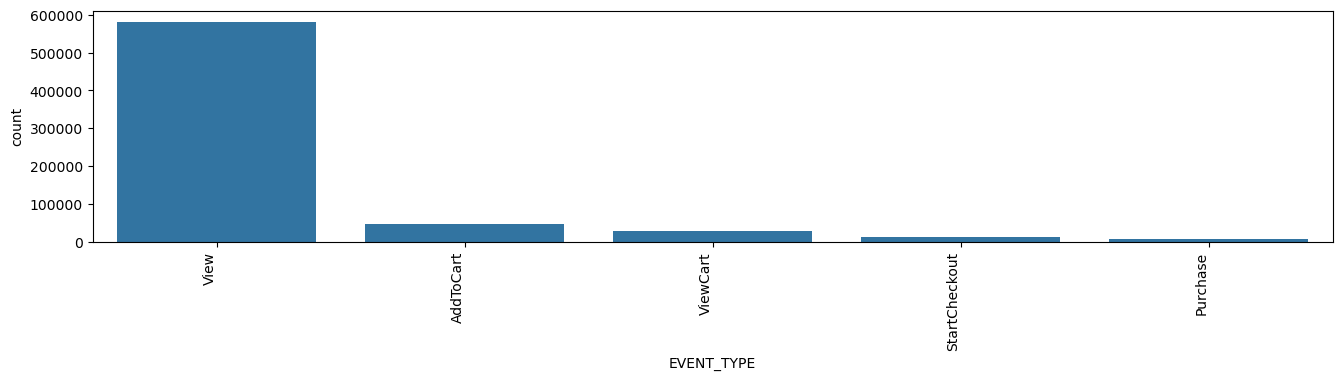

In [8]:
categorical_attributes = interaction_data.select_dtypes(include = ['object'])

plt.figure(figsize=(16,3))
chart = sns.countplot(data = categorical_attributes, x = 'EVENT_TYPE')
plt.xticks(rotation=90, horizontalalignment='right')
plt.show()

To use Amazon Personalize, you need to save timestamps in Unix Epoch format.

Lets validate that the timestamp is actually in a Unix Epoch format by converting it into a more easily understood time/date format

In [9]:
arb_time_stamp = interaction_data.iloc[50]['TIMESTAMP']
print('timestamp')
print(arb_time_stamp)
print()
print('Date & Time')
print(datetime.utcfromtimestamp(arb_time_stamp).strftime('%Y-%m-%d %H:%M:%S'))

timestamp
1716368521

Date & Time
2024-05-22 09:02:01


We will do some general summarization and inspection of the data to ensure that it will be helpful for Amazon Personalize

In [10]:
interaction_data.isnull().any()

ITEM_ID       False
USER_ID       False
EVENT_TYPE    False
TIMESTAMP     False
DISCOUNT      False
dtype: bool

In [11]:
interaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675004 entries, 0 to 675003
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ITEM_ID     675004 non-null  object
 1   USER_ID     675004 non-null  int64 
 2   EVENT_TYPE  675004 non-null  object
 3   TIMESTAMP   675004 non-null  int64 
 4   DISCOUNT    675004 non-null  object
dtypes: int64(2), object(3)
memory usage: 25.7+ MB


In [12]:
# save to local storage
interaction_data.to_csv(("./poc_data/data/interactions.csv"), index=False, float_format='%.0f')

### Explore the Users Dataset
[Back to top](#top)

<div class="alert alert-block alert-warning">
<b>Note:</b> This is a synthetic dataset and since it is randomly assigned, will be of little value to our model, in a real world scenario this data would be accurate to the user data.
</div>


In [13]:
user_data = pd.read_csv(raw_users_file_path)
pd.set_option('display.max_rows', 5)

user_data.head()

,USER_ID,AGE,GENDER
0,1,31,M
1,2,58,F
2,3,43,M
3,4,38,M
4,5,24,M


We can also leverage some syntectic user metadata to get some additional information about our users. 

In [14]:
user_metadata_df = pd.read_json (user_metadata_file_name)
user_metadata_df

,id,selectable_user,gender,first_name,last_name,email,age,name,username,persona,discount_persona,traits,platforms,addresses
0,1,True,M,Mark,Johnson,mark.johnson@example.com,31,Mark Johnson,user1,furniture_homedecor_housewares,lower_priced_products,{},{'ios': {'anonymous_id': '0822e8f3-6c03-4199-9...,"[{'first_name': 'Mark', 'last_name': 'Johnson'..."
1,2,True,F,Kristen,Calderon,kristen.calderon@example.com,58,Kristen Calderon,user2,tools_housewares_apparel,discount_indifferent,{},{'ios': {'anonymous_id': 'fc377a4c-4a15-444d-8...,"[{'first_name': 'Kristen', 'last_name': 'Calde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,5249,True,M,Vincent,Wells,vincent.wells@example.com,33,Vincent Wells,user5249,housewares_floral_seasonal,discount_indifferent,{},{'ios': {'anonymous_id': 'e3214a29-7376-4691-b...,"[{'first_name': 'Vincent', 'last_name': 'Wells..."
5249,5250,True,F,Monica,Garcia,monica.garcia@example.com,34,Monica Garcia,user5250,housewares_tools_beauty,discount_indifferent,{},{'ios': {'anonymous_id': 'c7d26d9d-2041-4dc6-a...,"[{'first_name': 'Monica', 'last_name': 'Garcia..."


In [15]:
# save to local storage
user_data.to_csv(("./poc_data/data/users.csv"), index=False, float_format='%.0f')

### Explore the Items Dataset

Let us look at the items dataset.

In [16]:
item_data = pd.read_csv(raw_items_file_path)
pd.set_option('display.max_rows', 5)

item_data.head()

,ITEM_ID,PRICE,CATEGORY_L1,CATEGORY_L2,PRODUCT_NAME,PRODUCT_DESCRIPTION,GENDER,PROMOTED
0,6579c22f-be2b-444c-a52b-0116dd82df6c,129.99,accessories,backpack,Adventure-Ready Expedition Backpack,Embark on your next outdoor journey with our r...,F,NaN
1,2e852905-c6f4-47db-802c-654013571922,149.99,accessories,backpack,Mauve Leather Daypack,This stylish mauve leather daypack combines el...,F,NaN
2,4ec7ff5c-f70f-4984-b6c4-c7ef37cc0c09,49.99,accessories,backpack,Lacy Crochet Summer Backpack,Embrace summer vibes with our Lacy Crochet Bac...,F,NaN
3,7977f680-2cf7-457d-8f4d-afa0aa168cb9,89.99,accessories,backpack,Adventure-Ready Rugged Backpack,Embark on your next journey with our Adventure...,F,NaN
4,b5649d7c-4651-458d-a07f-912f253784ce,189.99,accessories,backpack,Chic Caramel Leather Backpack,Elevate your everyday style with our Chic Cara...,F,NaN


In [17]:
# save to local storage
item_data.to_csv(("./poc_data/data/items.csv"), index=False, float_format='%.0f')

We are going to load some additional metadata about each item that will help make the recommended items more readable in this workshop. This is data you'd typically find in an item catalog system/database.

In [18]:
# load the item meta data
with open(item_metadata_file_name) as f:
    item_metadata_df = pd.json_normalize(yaml.load(f, Loader=yaml.FullLoader))[['id', 'name', 'category', 'style', 'featured']]
    
display(item_metadata_df)

,id,name,category,style,featured
0,6579c22f-be2b-444c-a52b-0116dd82df6c,Adventure-Ready Expedition Backpack,accessories,backpack,NaN
1,2e852905-c6f4-47db-802c-654013571922,Mauve Leather Daypack,accessories,backpack,NaN
...,...,...,...,...,...
2463,7000f6e7-41f7-4957-878a-ccc42a39ca59,Elegant Aroma Espresso Cup,hot dispensed,hot chocolate,NaN
2464,9c1a2048-7aac-4565-b836-d8d4f726322c,Crispy Golden Delight Chips,salty snacks,potato chips,NaN


# Creating Amazon Personalize Resources and Importing data <a class="anchor" id="import"></a>

## Configure an S3 bucket and an IAM  role <a class="anchor" id="bucket_role"></a>

So far, we have downloaded, manipulated, and saved the data onto the Amazon EBS instance attached to the instance running this Jupyter notebook.  

By default, the Personalize service does not have permission to access the data we upload into  S3 buckets in our account. In order to grant access to the Amazon Personalize service to interact with our S3 Buckets, we need to set a Bucket Policy and create an IAM role that the Amazon Personalize service will assume. If you are running this notebook without also running the Pretrained cloud formation template in the root folder then you will need to grant this Notebook substantial permissions in order to be able to run the code correctly.

If you are running this with the pretrained cloud formation template `PersonalizeIDPretrained.yaml` then the notebook will not need that level of permissioning and will obtain the permissions from the bucket created as part of the automation process for demonstration.

Use the metadata stored on the instance underlying this Amazon SageMaker notebook, to determine the region it is operating in. If you are using a Jupyter notebook outside of Amazon SageMaker, simply define the region as a string below. The Amazon S3 bucket needs to be in the same region as the Amazon Personalize resources we have been creating so far.

First, let us get the current notebook region.

In [19]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]

# To use a different region use:
# region = <your_region>

print('region:', region)

region: us-east-1


Amazon S3 bucket names are globally unique. To create a unique bucket name, the code below will append the string `personalize-poc-retail` to your AWS account number. Then it creates a bucket with this name in the region discovered in the previous cell. Note if you have already created a bucket as part of the cloud formation automation then the cell below will return information on that previously created bucket.

In [20]:
# Configure the SDK to SSM:
ssm = boto3.client('ssm')
s3 = boto3.client('s3')
bucket_found = False
try:
    personalizes3bucket = ssm.get_parameter(Name='/cloudformation/personalize-s3-bucket', WithDecryption=False)
    bucket_name = personalizes3bucket['Parameter']['Value']
    print('Bucket created as part of cloud formation template found')
    print('bucket_name:', bucket_name)
    bucket_found=True
except:
    
    account_id = boto3.client('sts').get_caller_identity().get('Account')
    bucket_name = account_id + "-" + region + "-" + "personalize-poc-retail"

    #getting existing buckets in the account
    response = s3.list_buckets()

    if bucket_name in [x['Name'] for x in response['Buckets']]:
        print("The bucket already exists.")
    else:
        if region == "us-east-1":
            bucket_responese = s3.create_bucket(Bucket=bucket_name)
        else:
            bucket_responese = s3.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region}
                )
    print('bucket_name:', bucket_name)

The bucket already exists.
bucket_name: 809697808660-us-east-1-personalize-poc-retail


Amazon Personalize needs to be able to read the contents of your S3 bucket. The policy which enables personalize to access the contents of the S3 bucket is below.

```python
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}
```

This S3 bucket policy allows Amazon Personalize to be able to read the contents of your S3 bucket. The code below creates and adds the policy to the bucket it created in the last step. If the bucket was created as part of the automation script then it merely shows the bucket that it created.

In [21]:
if bucket_found:
    bucket_current_policy = s3.get_bucket_policy(Bucket=bucket_name)['Policy']
    print("Policy for bucket created as part of cloud formation template:")
    print(json.loads(bucket_current_policy))
else:
    policy = {
        "Version": "2012-10-17",
        "Id": "PersonalizeS3BucketAccessPolicy",
        "Statement": [
            {
                "Sid": "PersonalizeS3BucketAccessPolicy",
                "Effect": "Allow",
                "Principal": {
                    "Service": "personalize.amazonaws.com"
                },
                "Action": [
                    "s3:GetObject",
                    "s3:ListBucket",
                    "s3:PutObject"
                ],
                "Resource": [
                    "arn:aws:s3:::{}".format(bucket_name),
                    "arn:aws:s3:::{}/*".format(bucket_name)
                ]
            }
        ]
    }

    bucket_current_policy = None

    try:
        bucket_current_policy = s3.get_bucket_policy(Bucket=bucket_name)['Policy']

    except s3.exceptions.from_code('NoSuchBucketPolicy') as e:    
        print("There is no current Bucket Policy for bucket " + bucket_name)

    except Exception as e: 
        raise(e)

    if (bucket_current_policy and policy == json.loads(bucket_current_policy)):
        print ("The policy is already associated with the S3 Bucket.")
    else:
        print ("Adding the policy to the bucket.")
        print(s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy)))

The policy is already associated with the S3 Bucket.


### Create an IAM role

Amazon Personalize also needs the ability to assume roles in AWS in order to have the permissions to execute certain tasks. Let's create an IAM role and attach the required policies to it. The code below attaches broad policies. You should use [more restrictive, least-privilege policies for production applications](https://docs.aws.amazon.com/IAM/latest/UserGuide/best-practices.html#grant-least-privilege). If you have run the cloud formation template the role will have been automatically created and we will simply obtain that one.

In [22]:
if bucket_found:
    print("Cloud formation template used - skipping creation of IAM role and needed policies for Personalize as they were already created as part of the automation script")
    role_arn_info = ssm.get_parameter(Name='/cloudformation/personalize-iam-role-arn', WithDecryption=False)
    role_arn = role_arn_info['Parameter']['Value']
    role_name = role_arn.split('/')[1]
    s3_access_policy_arn = 'arn:aws:iam::{}:policy/restrictedS3Access'.format(account_id)
else:
    iam = boto3.client("iam")

    role_name = account_id+"-PersonalizeS3-Immersion-Day"
    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Principal": {
                "Service": "personalize.amazonaws.com"
              },
                "Action": "sts:AssumeRole"
            }
        ]
    }

    # Create policy

    s3_access_policy_document = {
        "Version": "2012-10-17",
        "Statement": {
                "Sid" : "myStatement" ,
                "Effect": "Allow",
                "Resource": [
                    "arn:aws:s3:::{}".format(bucket_name),
                    "arn:aws:s3:::{}/*".format(bucket_name)
                ],
                "Action": "s3:*"
            }
    }

    try: 

        policy_response = iam.create_policy(
            PolicyName='restrictedS3Access',
            PolicyDocument=json.dumps(s3_access_policy_document),
            Description='Restricts access to only workshop S3 bucket'
        )

        s3_access_policy_arn = policy_response['Policy']['Arn']

        print ("s3_access_policy_arn:{}".format(s3_access_policy_arn))
    except:
        s3_access_policy_arn = 'arn:aws:iam::{}:policy/restrictedS3Access'.format(account_id)
        print ('The policy {} already exists.'.format(s3_access_policy_arn))
        print ('Using the existing policy')


    try:
        create_role_response = iam.create_role(
            RoleName = role_name,
            AssumeRolePolicyDocument = json.dumps(assume_role_policy_document),
        );
        role_arn = create_role_response["Role"]["Arn"]

        print ("10s pause to allow role to be fully consistent.")
        time.sleep(10)

    except iam.exceptions.EntityAlreadyExistsException as e:
        print('Warning: role already exists:', e)
        role_arn = iam.get_role(
            RoleName = role_name
        )["Role"]["Arn"];

    print('IAM Role: {}\n'.format(role_arn))

    # Attach the policy if it is not previously attached:
    if (s3_access_policy_arn in [ x['PolicyArn'] for x in iam.list_attached_role_policies( RoleName = role_name)['AttachedPolicies']]):
        print ('The policy {} is already attached to this role.'.format(s3_access_policy_arn))
    else:
        print ("Attaching the role_policy: {}".format(s3_access_policy_arn))
        attach_response = iam.attach_role_policy(
            RoleName = role_name,
            PolicyArn = s3_access_policy_arn
        );
        print ("30s pause to allow role to be fully consistent.")
        time.sleep(30)
        print('Done.')

The policy arn:aws:iam::809697808660:policy/restrictedS3Access already exists.
Using the existing policy
IAM Role: arn:aws:iam::809697808660:role/809697808660-PersonalizeS3-Immersion-Day

The policy arn:aws:iam::809697808660:policy/restrictedS3Access is already attached to this role.


### Upload data to S3

Now that your Amazon S3 bucket has been created, upload the CSV files of our 3 datasets (Item, Interaction and User).

<div class="alert alert-block alert-warning">
<b>Note:</b> NOTE: We will cover how to import real-time data in a future notebook..
</div>

In [23]:
try:
    s3.get_object(
        Bucket=bucket_name,
        Key="retail/interactions.csv",
    )
    print("{} already exists in the bucket {}".format("retail/interactions.csv", bucket_name))
except s3.exceptions.NoSuchKey:
    # Uploading the file if it does not already exist
    boto3.Session().resource('s3').Bucket(bucket_name).Object("retail/interactions.csv").upload_file("./poc_data/data/interactions.csv")
    print("File {} uploaded to bucket {}".format("retail/interactions.csv", bucket_name))

try:
    s3.get_object(
        Bucket=bucket_name,
        Key="retail/items.csv",
    )
    print("{} already exists in the bucket {}".format("retail/items.csv", bucket_name))
except s3.exceptions.NoSuchKey:
    # Uploading the file if it does not already exist     
    boto3.Session().resource('s3').Bucket(bucket_name).Object("retail/items.csv").upload_file("./poc_data/data/items.csv")
    print("File {} uploaded to bucket {}".format("retail/items.csv", bucket_name))

try:
    s3.get_object(
        Bucket=bucket_name,
        Key="retail/users.csv",
    )
    print("{} already exists in the bucket {}".format("retail/users.csv", bucket_name))
except s3.exceptions.NoSuchKey:
    # Uploading the file if it does not already exist
    boto3.Session().resource('s3').Bucket(bucket_name).Object("retail/users.csv").upload_file("./poc_data/data/users.csv")
    print("File {} uploaded to bucket {}".format("retail/users.csv", bucket_name))

retail/interactions.csv already exists in the bucket 809697808660-us-east-1-personalize-poc-retail
retail/items.csv already exists in the bucket 809697808660-us-east-1-personalize-poc-retail
retail/users.csv already exists in the bucket 809697808660-us-east-1-personalize-poc-retail


## Create dataset group <a class="anchor" id="group_dataset"></a>
[Back to top](#top)

The highest level of isolation and abstraction with Amazon Personalize is a *dataset group*. Information stored within one of these dataset groups has no impact on any other dataset group or models created from one – they are completely isolated. This allows you to run many experiments and is part of how we keep your models private and fully trained only on your data. 

Before importing the data prepared earlier, there needs to be a dataset group and a dataset added to it that handles the interactions.

Dataset groups can house the following types of information:

* User-item-interactions
* Event streams (real-time interactions)
* User metadata
* Item metadata

We need to create the dataset group that will contain our three datasets.

Your dataset group can be one of the following types:

* A Domain dataset group, where you create preconfigured resources for different business domains and use cases, such as getting recommendations for similar videos (VIDEO_ON_DEMAND domain) or best selling items (ECOMMERCE domain). You choose your business domain, import your data, and create recommenders. You use recommenders in your application to get recommendations. Use a [Domain dataset group](https://docs.aws.amazon.com/personalize/latest/dg/domain-dataset-groups.html) if you have a video on demand or e-commerce application and want Amazon Personalize to find the best configurations for your use cases. If you start with a Domain dataset group, you can also add custom resources such as solutions with solution versions trained with recipes for custom use cases.


* A [Custom dataset group](https://docs.aws.amazon.com/personalize/latest/dg/custom-dataset-groups.html), where you create configurable resources for custom use cases and batch recommendation workflows. You select a recipe, train a solution version (model), and deploy the solution version with a campaign. You use a campaign in your application to get recommendations. Use a Custom dataset group if you don't have a video on demand or e-commerce application or want to configure and manage only custom resources, or want to get recommendations in a batch workflow. If you start with a Custom dataset group, you can't associate it with a domain later. Instead, create a new Domain dataset group.

You can create and manage Domain dataset groups and Custom dataset groups with the AWS console, the AWS Command Line Interface (AWS CLI), or programmatically with the AWS SDKs.

<div class="alert alert-block alert-warning">
<b>Note:</b> If you are running this as part of an AWS workshop, the resources have been created ahead of time, this is to eliminate the time spent waiting for the data to import, models to train and recommenders to deploy. In these notebooks will check to see if the resources exist and use them. You may see “Resource X Already exists” messages, if you run these notebooks in your own account, it will create these resources, which will add approximately 90 minutes to this workshop.
</div>


#### Create Dataset Group
The following cell will create a new dataset group with the name `personalize-poc-retail`.


In [24]:
try:     
    # Try to create the dataset group, this block with exectute fully if the dataset group does not exist yet
    
    create_dataset_group_response = personalize.create_dataset_group(
        name = workshop_dataset_group_name,
        domain='ECOMMERCE'
    )
    workshop_dataset_group_arn = create_dataset_group_response['datasetGroupArn']
    print(json.dumps(create_dataset_group_response, indent=2))
    print ('\nCreating the Dataset Group with dataset_group_arn = {}'.format(workshop_dataset_group_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException as e:
    # if the dataset group already exists, get the unique identifier workshop_dataset_group_arn 
    # from the existing resource
    
    workshop_dataset_group_arn = 'arn:aws:personalize:'+region+':'+account_id+':dataset-group/'+workshop_dataset_group_name 
    print ('\nThe the Dataset Group with dataset_group_arn = {} already exists'.format(workshop_dataset_group_arn))
    print ('\nWe will be using the existing Dataset Group dataset_group_arn = {}'.format(workshop_dataset_group_arn))



The the Dataset Group with dataset_group_arn = arn:aws:personalize:us-east-1:809697808660:dataset-group/personalize-immersion-day-retail already exists

We will be using the existing Dataset Group dataset_group_arn = arn:aws:personalize:us-east-1:809697808660:dataset-group/personalize-immersion-day-retail


#### Wait for Dataset Group to Have ACTIVE Status

Before we can use the dataset group, it must be active. This can take a minute or two. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the dataset group every 60 seconds, up to a maximum of 3 hours.

In [25]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = workshop_dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

DatasetGroup: ACTIVE


Now that you have a dataset group, you can create a dataset for the interaction data.

## Create the Interactions Schema <a class="anchor" id="interact_schema"></a>
[Back to top](#top)

Now that we've loaded and prepared our three datasets, we'll need to configure the Amazon Personalize service to understand our data so that it can be used to train models for generating recommendations. Amazon Personalize requires a schema for each dataset, so it can map the columns in our CSVs to fields for model training. Each schema is declared in JSON using the [Apache Avro](https://avro.apache.org/) format. 

First, define a schema to tell Amazon Personalize what type of dataset you are uploading. There are several reserved and mandatory keywords required in the schema, based on the type of dataset. More detailed information can be found in the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

Here, you will create a schema for interactions data, which requires the `USER_ID`, `ITEM_ID`, and `TIMESTAMP` fields. These must be defined in the same order in the schema as they appear in the dataset.

For this dataset we also have an `EVENT_TYPE` column that includes multiple common eCommerce event types (`View`, `AddToCart`, `Purchase`, and so on).

The interactions dataset supports metadata columns. Interaction metadata columns are a way to provide contextual details that are specific to an interaction, such as the user's current device type (phone, tablet, desktop, set-top box, etc), the user's current location (city, region, metro code, etc), current weather conditions, and so on. For this dataset, we have a `DISCOUNT` column that indicates whether the user is interacting with an item that is currently discounted (`Yes`/`No`). It's being used to learn a user's affinity for items that are on sale or not.

In [26]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",  # "View", "Purchase", etc.
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "DISCOUNT",  # This is the contextual metadata - "Yes" or "No".
            "type": "string",
            "categorical": True,
        },
    ],
    "version": "1.0"
}

try:
    # Try to create the interactions dataset schema, this block with exectute fully 
    # if the interactions dataset schema does not exist yet
    create_schema_response = personalize.create_schema(
        name = interactions_schema_name,
        schema = json.dumps(interactions_schema),
        domain='ECOMMERCE'
    )
    print(json.dumps(create_schema_response, indent=2))
    workshop_interactions_schema_arn = create_schema_response['schemaArn']
    print ('\nCreating the Interactions Schema with workshop_interactions_schema_arn = {}'.format(workshop_interactions_schema_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the interactions dataset schema already exists, get the unique identifier workshop_interactions_schema_arn
    # from the existing resource 
    
    workshop_interactions_schema_arn = 'arn:aws:personalize:'+region+':'+account_id+':schema/'+interactions_schema_name 
    print('The schema {} already exists.'.format(workshop_interactions_schema_arn))
    print ('\nWe will be using the existing Interactions Schema with workshop_interactions_schema_arn = {}'.format(workshop_interactions_schema_arn))
 

The schema arn:aws:personalize:us-east-1:809697808660:schema/workshop_retail_interactions_schema already exists.

We will be using the existing Interactions Schema with workshop_interactions_schema_arn = arn:aws:personalize:us-east-1:809697808660:schema/workshop_retail_interactions_schema


### Create the interactions dataset

With a schema created, you can create a dataset within the dataset group. Note that this does not load the data yet, but creates a schema of what the data looks like. 

In [27]:
try:
    # Try to create the interactions dataset, this block with exectute fully 
    # if the interactions dataset does not exist yet
    
    dataset_type = 'INTERACTIONS'
    create_dataset_response = personalize.create_dataset(
        name = interactions_dataset_name,
        datasetType = dataset_type,
        datasetGroupArn = workshop_dataset_group_arn,
        schemaArn = workshop_interactions_schema_arn
    )

    workshop_interactions_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))
    print ('\nCreating the Interactions Dataset with workshop_interactions_dataset_arn = {}'.format(workshop_interactions_dataset_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the interactions dataset already exists, get the unique identifier workshop_interactions_dataset_arn 
    # from the existing resource 
    workshop_interactions_dataset_arn =  'arn:aws:personalize:'+region+':'+account_id+':dataset/'+workshop_dataset_group_name+'/INTERACTIONS'
    print('The Interactions Dataset {} already exists.'.format(workshop_interactions_dataset_arn))
    print ('\nWe will be using the existing Interactions Dataset with workshop_interactions_dataset_arn = {}'.format(workshop_interactions_dataset_arn))
        

The Interactions Dataset arn:aws:personalize:us-east-1:809697808660:dataset/personalize-immersion-day-retail/INTERACTIONS already exists.

We will be using the existing Interactions Dataset with workshop_interactions_dataset_arn = arn:aws:personalize:us-east-1:809697808660:dataset/personalize-immersion-day-retail/INTERACTIONS


## Create the Items (Products) schema<a class="anchor" id="items_schema"></a>
[Back to top](#top)

First, define a schema to tell Amazon Personalize what type of dataset you are uploading. There are several reserved and mandatory keywords required in the schema, based on the type of dataset. More detailed information can be found in the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

The items dataset schema requires an `ITEM_ID` column and at least one metadata column. Up to 50 metadata columns can be added to the items dataset.

For this dataset we have three metadata columns: `PRICE`, `CATEGORY_L1`, `CATEGORY_L2`, `PRODUCT_DESCRIPTION`, and `GENDER` (see schema definition in the cell below). 

We mapped the `category` and `style` fields from the items catalog to the `CATEGORY_L1` and `CATEGORY_L2` columns to indicate category levels. The `gender_affinity` field used to indicate Women's and Men's products (clothing, footwear, etc.) has been mapped to the `GENDER` column in the schema. 

Note that `CATEGORY_L1`, `CATEGORY_L2`, and `GENDER` are annotated as being categorical (`"categorical": true`). This tells Personalize to interpret the column value for each row as one or more categorical values, where the `|` character can be used to separate values. For example, `value1|value2|value3`. The `PRODUCT_DESCRIPTION` column is annotated as being a text column (`"textual": true`). This tells Personalize that this column contains unstructured text. A natural language processing (NLP) model is used to extract features from the textual column to use as features in the model. Including a textual column in your items dataset can significantly enhance the relevancy of recommendations. Currently, only one textual column can be included in the items dataset and the text must be in English. For more information, please refer to [the documentation](https://docs.aws.amazon.com/personalize/latest/dg/items-datasets.html#text-data).

In [28]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "PRICE",
            "type": "float"
        },
        {
            "name": "CATEGORY_L1",
            "type": "string",
            "categorical": True
        },
        {
            "name": "CATEGORY_L2",
            "type": "string",
            "categorical": True
        },
        {
            "name": "PRODUCT_DESCRIPTION",
            "type": "string",
            "textual": True
        },
        {
            "name": "GENDER",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

try:
    # Try to create the items dataset schema, this block with exectute fully 
    # if the items dataset schema does not exist yet
    
    create_schema_response = personalize.create_schema(
        name = items_schema_name,
        schema = json.dumps(items_schema),
        domain='ECOMMERCE'
    )
    workshop_items_schema_arn = create_schema_response['schemaArn']
    print(json.dumps(create_schema_response, indent=2))

    print ('\nCreating the Items Schema with workshop_items_schema_arn = {}'.format(workshop_items_schema_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the items dataset schema already exists, get the unique identifier workshop_items_schema_arn 
    # from the existing resource 
    
    workshop_items_schema_arn = 'arn:aws:personalize:'+region+':'+account_id+':schema/'+items_schema_name 
    print('The schema {} already exists.'.format(workshop_items_schema_arn))
    print ('\nWe will be using the existing Items Schema with workshop_items_schema_arn = {}'.format(workshop_items_schema_arn))
 

The schema arn:aws:personalize:us-east-1:809697808660:schema/workshop_retail_items_schema already exists.

We will be using the existing Items Schema with workshop_items_schema_arn = arn:aws:personalize:us-east-1:809697808660:schema/workshop_retail_items_schema


### Create Items Dataset
With a schema created, you can create a dataset within the dataset group. Note that this does not load the data yet, but creates a schema of what the data looks like. 

In [29]:
try:
    # Try to create the items dataset, this block with execute fully if the items dataset does not exist yet
    
    dataset_type = "ITEMS"
    create_dataset_response = personalize.create_dataset(
        name = items_dataset_name,
        datasetType = dataset_type,
        datasetGroupArn = workshop_dataset_group_arn,
        schemaArn = workshop_items_schema_arn
    )

    workshop_items_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))

    print ('\nCreating the Items Dataset with workshop_items_dataset_arn = {}'.format(workshop_items_dataset_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the items dataset already exists, get the unique identifier workshop_items_dataset_arn 
    # from the existing resource 
    
    workshop_items_dataset_arn =  'arn:aws:personalize:'+region+':'+account_id+':dataset/'+workshop_dataset_group_name+'/ITEMS'
    print('The Items Dataset {} already exists.'.format(workshop_items_dataset_arn))
    print ('\nWe will be using the existing Items Dataset with workshop_items_dataset_arn = {}'.format(workshop_items_dataset_arn))   

The Items Dataset arn:aws:personalize:us-east-1:809697808660:dataset/personalize-immersion-day-retail/ITEMS already exists.

We will be using the existing Items Dataset with workshop_items_dataset_arn = arn:aws:personalize:us-east-1:809697808660:dataset/personalize-immersion-day-retail/ITEMS


## Create the Users schema<a class="anchor" id="users_schema"></a>
[Back to top](#top)

First, define a schema to tell Amazon Personalize what type of dataset you are uploading. There are several reserved and mandatory keywords required in the schema, based on the type of dataset. More detailed information can be found in the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

Here, you will create a schema for user data, which requires the `USER_ID`, and an additonal metadata field. For this dataset we have metadata columns for `AGE` and `GENDER`. These must be defined in the same order in the schema as they appear in the dataset.

In [30]:
users_schema = {
    "type": "record",
    "name": "Users",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "AGE",
            "type": "int"
        },
        {
            "name": "GENDER",
            "type": "string",
            "categorical": True,
        }
    ],
    "version": "1.0"
}

try:
    # Try to create the users dataset schema, this block with exectute fully 
    # if the users dataset schema does not exist yet
    
    create_schema_response = personalize.create_schema(
        name = users_schema_name,
        schema = json.dumps(users_schema),
        domain='ECOMMERCE'
    )
    
    workshop_users_schema_arn = create_schema_response['schemaArn']
    print(json.dumps(create_schema_response, indent=2))

    print ('\nCreating the Users Schema with workshop_users_schema_arn = {}'.format(workshop_users_schema_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the users dataset schema already exists, get the unique identifier workshop_users_schema_arn 
    # from the existing resource 

    workshop_users_schema_arn = 'arn:aws:personalize:'+region+':'+account_id+':schema/'+users_schema_name 
    print('The schema {} already exists.'.format(workshop_users_schema_arn))
    print ('\nWe will be using the existing Users Schema with workshop_users_schema_arn = {}'.format(workshop_users_schema_arn))
 

The schema arn:aws:personalize:us-east-1:809697808660:schema/workshop_retail_users_schema already exists.

We will be using the existing Users Schema with workshop_users_schema_arn = arn:aws:personalize:us-east-1:809697808660:schema/workshop_retail_users_schema


### Create Users Dataset

In [31]:
try:
    # Try to create the users dataset, this block with exectute fully if the users dataset does not exist yet
    
    dataset_type = "USERS"
    create_dataset_response = personalize.create_dataset(
        name = users_dataset_name,
        datasetType = dataset_type,
        datasetGroupArn = workshop_dataset_group_arn,
        schemaArn = workshop_users_schema_arn
    )

    workshop_users_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))

    print ('\nCreating the Users Dataset with workshop_users_dataset_arn = {}'.format(workshop_users_dataset_arn))
    
except personalize.exceptions.ResourceAlreadyExistsException:
    # if the users dataset already exists, get the unique identifier workshop_users_dataset_arn
    # from the existing resource 
    
    workshop_users_dataset_arn =  'arn:aws:personalize:'+region+':'+account_id+':dataset/'+workshop_dataset_group_name+'/USERS'
    print('The Users Dataset {} already exists.'.format(workshop_users_dataset_arn))
    print ('\nWe will be using the existing Users Dataset with workshop_users_dataset_arn = {}'.format(workshop_users_dataset_arn))

The Users Dataset arn:aws:personalize:us-east-1:809697808660:dataset/personalize-immersion-day-retail/USERS already exists.

We will be using the existing Users Dataset with workshop_users_dataset_arn = arn:aws:personalize:us-east-1:809697808660:dataset/personalize-immersion-day-retail/USERS


Let's wait untill all the datasets have been created.

In [32]:
%%time

max_time = time.time() + 6*60*60 # 6 hours
while time.time() < max_time:
    describe_dataset_response = personalize.describe_dataset(
        datasetArn = workshop_interactions_dataset_arn
    )
    status_interaction_dataset =  describe_dataset_response["dataset"]['status']
    print("Interactions Dataset: {}".format(status_interaction_dataset))
    
    if status_interaction_dataset == "ACTIVE":
        print("Build succeeded for {}".format(workshop_interactions_dataset_arn))
        
    elif status_interaction_dataset == "CREATE FAILED":
        print("Build failed for {}".format(workshop_interactions_dataset_arn))
        break
        
    if not status_interaction_dataset == "ACTIVE":
        print("The interaction dataset creation is still in progress")
    else:
        print("The interaction dataset  is ACTIVE")
        

    describe_dataset_response = personalize.describe_dataset(
        datasetArn = workshop_items_dataset_arn
    )
    status_item_dataset =  describe_dataset_response["dataset"]['status']
    print("Items Dataset: {}".format(status_item_dataset))
    
    if status_item_dataset == "ACTIVE":
        print("Build succeeded for {}".format(workshop_items_dataset_arn))
        
    elif status_item_dataset == "CREATE FAILED":
        print("Build failed for {}".format(workshop_items_dataset_arn))
        break
        
    if not status_item_dataset == "ACTIVE":
        print("The item dataset creation is still in progress")
    else:
        print("The item dataset  is ACTIVE")
    
    describe_dataset_response = personalize.describe_dataset(
        datasetArn = workshop_users_dataset_arn
    )
    status_user_dataset =  describe_dataset_response["dataset"]['status']
    print("Users Dataset: {}".format(status_user_dataset))
    
    if status_user_dataset == "ACTIVE":
        print("Build succeeded for {}".format(workshop_users_dataset_arn))
        
    elif status_user_dataset == "CREATE FAILED":
        print("Build failed for {}".format(workshop_users_dataset_arn))
        break
        
    if not status_user_dataset == "ACTIVE":
        print("The user dataset creation is still in progress")
    else:
        print("The user dataset  is ACTIVE")
    
    if status_interaction_dataset == "ACTIVE" and status_item_dataset == "ACTIVE" and status_user_dataset == 'ACTIVE':
        break
        
    time.sleep(30)

Interactions Dataset: ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:809697808660:dataset/personalize-immersion-day-retail/INTERACTIONS
The interaction dataset  is ACTIVE
Items Dataset: ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:809697808660:dataset/personalize-immersion-day-retail/ITEMS
The item dataset  is ACTIVE
Users Dataset: ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:809697808660:dataset/personalize-immersion-day-retail/USERS
The user dataset  is ACTIVE
CPU times: user 8.73 ms, sys: 117 μs, total: 8.84 ms
Wall time: 70.6 ms


## Import the Interactions <a class="anchor" id="import_interactions"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, now you will execute an import job that will load the item data from the S3 bucket into the Amazon Personalize dataset. 

In [33]:
# Check if the import job already exists

# List the import jobs
interactions_dataset_import_jobs = personalize.list_dataset_import_jobs(
    datasetArn=workshop_interactions_dataset_arn,
    maxResults=100
)['datasetImportJobs']

#check if there is an existing job with the prefix
job_exists = False  
job_arn = None

for job in interactions_dataset_import_jobs:
    if (interactions_import_job_name in job['jobName']):
        job_exists = True
        job_arn = job['datasetImportJobArn']
    
if (job_exists):
    workshop_interactions_dataset_import_job_arn = job_arn
    print('The Interactions Import Job {} already exists.'.format(workshop_interactions_dataset_import_job_arn))
    print ('\nWe will be using the existing Interactions Import Job with workshop_interactions_dataset_import_job_arn = {}'.format(workshop_interactions_dataset_import_job_arn))
        
else:
    # If there is no import job with the prefix, create it:   
    create_dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = interactions_import_job_name,
        datasetArn = workshop_interactions_dataset_arn,
        dataSource = {
            "dataLocation": "s3://{}/{}".format(bucket_name, "retail/interactions.csv")
        },
        roleArn = role_arn
    )
    workshop_interactions_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
    print(json.dumps(create_dataset_import_job_response, indent=2))
    
    print ('\nImporting the Interactions Data with workshop_interactions_dataset_import_job_arn = {}'.format(workshop_interactions_dataset_import_job_arn))


The Interactions Import Job arn:aws:personalize:us-east-1:809697808660:dataset-import-job/dataset_import_interaction already exists.

We will be using the existing Interactions Import Job with workshop_interactions_dataset_import_job_arn = arn:aws:personalize:us-east-1:809697808660:dataset-import-job/dataset_import_interaction


## Import the Item Metadata <a class="anchor" id="import_items"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, now you will execute an import job that will load the item data from the S3 bucket into the Amazon Personalize dataset. 

In [34]:
# Checking if the import job already exists

# List the import jobs
items_dataset_import_jobs = personalize.list_dataset_import_jobs(
    datasetArn=workshop_items_dataset_arn,
    maxResults=100
)['datasetImportJobs']

job_exists = False
job_arn = None

#check if there is an existing job with the prefix
for job in items_dataset_import_jobs:
    if (items_import_job_name in job['jobName']):
        job_exists = True
        job_arn = job['datasetImportJobArn']
    
if (job_exists):
    workshop_items_dataset_import_job_arn =  job_arn
    print('The Items Import Job {} already exists.'.format(workshop_items_dataset_import_job_arn))
    print ('\nWe will be using the existing Items Import Job with workshop_items_dataset_import_job_arn = {}'.format(workshop_items_dataset_import_job_arn))
        
else:
    # If there is no import job with the prefix, create it:    
    create_dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = items_import_job_name,
        datasetArn = workshop_items_dataset_arn,
        dataSource = {
            "dataLocation": "s3://{}/{}".format(bucket_name, "retail/items.csv")
        },
        roleArn = role_arn
    )

    workshop_items_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
    print(json.dumps(create_dataset_import_job_response, indent=2))
    print ('\nImporting the Items Data with workshop_items_dataset_import_job_arn = {}'.format(workshop_items_dataset_import_job_arn))
    
    

The Items Import Job arn:aws:personalize:us-east-1:809697808660:dataset-import-job/dataset_import_item already exists.

We will be using the existing Items Import Job with workshop_items_dataset_import_job_arn = arn:aws:personalize:us-east-1:809697808660:dataset-import-job/dataset_import_item


## Import the User Metadata <a class="anchor" id="import_users"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, now you will execute an import job that will load the user data from the S3 bucket into the Amazon Personalize dataset. 

In [35]:
# Checking if the import job already exists

# List the import jobs
users_dataset_import_jobs = personalize.list_dataset_import_jobs(
    datasetArn=workshop_users_dataset_arn,
    maxResults=100
)['datasetImportJobs']

#check if there is an existing job with the prefix
job_exists = False 
job_arn = None      
for job in users_dataset_import_jobs:
    if (users_import_job_name in job['jobName']):
        job_exists = True
        job_arn = job['datasetImportJobArn']

if (job_exists):
    workshop_users_dataset_import_job_arn =  job_arn
    print('The Users Import Job {} already exists.'.format(workshop_users_dataset_import_job_arn))
    print ('\nWe will be using the existing Users Import Job with workshop_users_dataset_import_job_arn = {}'.format(workshop_users_dataset_import_job_arn))
        
else:
    # If there is no import job with the prefix, create it:  
    create_dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = users_import_job_name,
        datasetArn = workshop_users_dataset_arn,
        dataSource = {
            "dataLocation": "s3://{}/{}".format(bucket_name, "retail/users.csv")
        },
        roleArn = role_arn
    )

    workshop_users_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
    print(json.dumps(create_dataset_import_job_response, indent=2))
    
    print ('\nImporting the Users Data with workshop_users_dataset_import_job_arn = {}'.format(workshop_users_dataset_import_job_arn))
    
    

The Users Import Job arn:aws:personalize:us-east-1:809697808660:dataset-import-job/dataset_import_user already exists.

We will be using the existing Users Import Job with workshop_users_dataset_import_job_arn = arn:aws:personalize:us-east-1:809697808660:dataset-import-job/dataset_import_user


### Wait for Import Jobs to Complete

Before we can use the dataset, the import job must be active. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the import job every minute, up to a maximum of 6 hours.

It will take 10-15 minutes for the import jobs to complete. While you're waiting you can learn more about Datasets and Schemas in [the documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

We will wait for all three jobs to finish.

In [36]:
max_time = time.time() + 6*60*60 # 10 hours
while time.time() < max_time:

    # Interactions dataset import
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = workshop_interactions_dataset_import_job_arn
    )
    status_interactions_import = describe_dataset_import_job_response["datasetImportJob"]['status']
    
    if status_interactions_import == "ACTIVE":
        print("Build succeeded for {}".format(workshop_interactions_dataset_import_job_arn))
        
    elif status_interactions_import == "CREATE FAILED":
        print("Build failed for {}".format(workshop_interactions_dataset_import_job_arn))
        break
        
    if not status_interactions_import == "ACTIVE":
        print("The interactions dataset import is still in progress")
    else:
        print("The interactions dataset import is ACTIVE")

    # Items dataset import
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = workshop_items_dataset_import_job_arn
    )
    status_items_import = describe_dataset_import_job_response["datasetImportJob"]['status']
    
    if status_items_import == "ACTIVE":
        print("Build succeeded for {}".format(workshop_items_dataset_import_job_arn))
        
    elif status_items_import == "CREATE FAILED":
        print("Build failed for {}".format(workshop_items_dataset_import_job_arn))
        break
        
    if not status_items_import == "ACTIVE":
        print("The items dataset import is still in progress")
    else:
        print("The items dataset import is ACTIVE")
        
        
   # Users dataset import  
    describe_users_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = workshop_users_dataset_import_job_arn
    )
    status_users_import = describe_users_dataset_import_job_response["datasetImportJob"]['status']
    
    if status_users_import == "ACTIVE":
        print("Build succeeded for {}".format(workshop_users_dataset_import_job_arn))
        
    elif status_users_import == "CREATE FAILED":
        print("Build failed for {}".format(workshop_users_dataset_import_job_arn))
        break
        
    if not status_users_import == "ACTIVE":
        print("The user dataset import is still in progress")
    else:
        print("The user dataset import is ACTIVE")
        

    if status_interactions_import == "ACTIVE" and status_items_import == 'ACTIVE' and status_users_import  == 'ACTIVE':
        break

    print()
    time.sleep(30)

Build succeeded for arn:aws:personalize:us-east-1:809697808660:dataset-import-job/dataset_import_interaction
The interactions dataset import is ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:809697808660:dataset-import-job/dataset_import_item
The items dataset import is ACTIVE
Build succeeded for arn:aws:personalize:us-east-1:809697808660:dataset-import-job/dataset_import_user
The user dataset import is ACTIVE


With all imports now complete you can  start training recommenders and solutions. Run the cell below before moving on to store a few values for usage in the next notebooks. After completing that cell open notebook `02_Training_Layer.ipynb` to continue.

## Storing Useful Variables <a class="anchor" id="vars"></a>
[Back to top](#top)

Before exiting this notebook, run the following cells to save the version ARNs for use in the next notebook.

In [37]:
%store data_dir
%store workshop_dataset_group_arn
%store workshop_interactions_dataset_arn
%store workshop_items_dataset_arn
%store workshop_users_dataset_arn
%store workshop_interactions_schema_arn
%store workshop_items_schema_arn
%store workshop_users_schema_arn
%store workshop_rerank_solution_name
%store workshop_rerank_campaign_name

%store recommender_customers_who_viewed_name
%store recommender_recommended_for_you_name

%store region
%store account_id
%store role_name
%store role_arn

%store bucket_name

%store item_metadata_df
%store user_metadata_df

%store s3_access_policy_arn

Stored 'data_dir' (str)
Stored 'workshop_dataset_group_arn' (str)
Stored 'workshop_interactions_dataset_arn' (str)
Stored 'workshop_items_dataset_arn' (str)
Stored 'workshop_users_dataset_arn' (str)
Stored 'workshop_interactions_schema_arn' (str)
Stored 'workshop_items_schema_arn' (str)
Stored 'workshop_users_schema_arn' (str)
Stored 'workshop_rerank_solution_name' (str)
Stored 'workshop_rerank_campaign_name' (str)
Stored 'recommender_customers_who_viewed_name' (str)
Stored 'recommender_recommended_for_you_name' (str)
Stored 'region' (str)
Stored 'account_id' (str)
Stored 'role_name' (str)
Stored 'role_arn' (str)
Stored 'bucket_name' (str)
Stored 'item_metadata_df' (DataFrame)
Stored 'user_metadata_df' (DataFrame)
Stored 's3_access_policy_arn' (str)


[Go to the next notebook `Retail_02_Training_Layer.ipynb`](Retail_02_Training_Layer.ipynb) to continue.